# Pharmaceutical Sales prediction across multiple stores

### Table of Contents
* [Libraries](#Libraries)
* [Datasets](#Datasets)
* [Preprocessing](#Preprocessing)
* [Exploration of customer purchasing](#Exploration-of-customer-purchasing)
   * [Seasonality Analysis](#Seasonality-Analysis)

## Libraries

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

## Datasets

In [2]:
train_data = pd.read_csv("rossmann-store-sales/train.csv")
test_data = pd.read_csv("rossmann-store-sales/test.csv")
store_data = pd.read_csv("rossmann-store-sales/store.csv")

c:\users\ajikobi oluwasegun\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, o = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Preprocessing

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### Treating Missing Values

In [9]:
## Checking for null values in test data
test_data.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [10]:
## Function to treat missing data
def fillna_mode(df):
    for col in df.columns:
        if df[col].isnull().values.any():
            mode = df[col].mode()[0]
            df[col].fillna(mode, inplace=True)
    return df.isna().sum()

In [11]:
## Treating null values in test_data
fillna_mode(test_data)

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [12]:
## Checking for null values in store data
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
## Checking percentage of null values
null = store_data.isna().sum().sort_values(ascending = False)
null_per = (null/len(store_data)) * 100
null_perc = pd.DataFrame(null_per)
null_perc

,0
PromoInterval,48.789238
Promo2SinceYear,48.789238
Promo2SinceWeek,48.789238
CompetitionOpenSinceYear,31.748879
CompetitionOpenSinceMonth,31.748879
CompetitionDistance,0.269058
Promo2,0.000000
Assortment,0.000000
StoreType,0.000000
Store,0.000000


In [14]:
## Treating null values in test_data
fillna_mode(store_data)

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [15]:
test_data["DayOfWeek"].unique()

array([4, 3, 2, 1, 7, 6, 5], dtype=int64)

#### Converting categorical columns to object across the three datasets

In [16]:
## Converting categorical columns in train_data to object
train_cols = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
for col in train_cols:
    train_data = train_data.astype({col:'object'})

## Converting the date column to the datetime format
train_data['Date'] = pd.to_datetime(train_data.Date)

In [17]:
## Converting categorical columns in test_data to object
for col in train_cols:
    test_data = test_data.astype({col:'object'})

## Converting the date column to datetime format 
test_data['Date'] = pd.to_datetime(test_data.Date)

In [18]:
## Converting categorical columns in store_data to object
store_cols = ['StoreType','Assortment','CompetitionOpenSinceMonth','Promo2']
for col in store_cols:
    store_data = store_data.astype({col:'object'})

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  object        
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  object        
 6   Promo          1017209 non-null  object        
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 69.8+ MB


In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  object        
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41088 non-null  object        
 5   Promo          41088 non-null  object        
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.5+ MB


In [21]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   object 
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   object 
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 87.2+ KB


#### Replacing values to deal with Cardinality

In [22]:
train_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [23]:
test_data['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

In [24]:
## Dealing with cardinality
train_data['StateHoliday'].replace({0:'o','0':'o'},inplace=True)
test_data['StateHoliday'].replace({'0':'o'},inplace=True)

In [25]:
train_data['StateHoliday'].unique()

array(['o', 'a', 'b', 'c'], dtype=object)

In [26]:
test_data['StateHoliday'].unique()

array(['o', 'a'], dtype=object)

#### Checking for unique values in all columns across datasets

In [27]:
## A function to get all unique values in the categorical variables

def unique_vals(df):
    for col in df.columns:
        if df[col].dtype == 'O':
            print('Unique values in',col,'are',df[col].unique())
            print('----------------------------------------------')
            
            
for data in [train_data,test_data,store_data]:
    unique_vals(data)

Unique values in DayOfWeek are [5 4 3 2 1 7 6]
----------------------------------------------
Unique values in Open are [1 0]
----------------------------------------------
Unique values in Promo are [1 0]
----------------------------------------------
Unique values in StateHoliday are ['o' 'a' 'b' 'c']
----------------------------------------------
Unique values in SchoolHoliday are [1 0]
----------------------------------------------
Unique values in DayOfWeek are [4 3 2 1 7 6 5]
----------------------------------------------
Unique values in Open are [1.0 0.0]
----------------------------------------------
Unique values in Promo are [1 0]
----------------------------------------------
Unique values in StateHoliday are ['o' 'a']
----------------------------------------------
Unique values in SchoolHoliday are [0 1]
----------------------------------------------
Unique values in StoreType are ['c' 'a' 'd' 'b']
----------------------------------------------
Unique values in Assortment 

## Exploration of customer purchasing

In [28]:
train_data.describe()

,Store,Sales,Customers
count,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,5.773819e+03,6.331459e+02
std,3.219087e+02,3.849926e+03,4.644117e+02
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,3.727000e+03,4.050000e+02
50%,5.580000e+02,5.744000e+03,6.090000e+02
75%,8.380000e+02,7.856000e+03,8.370000e+02
max,1.115000e+03,4.155100e+04,7.388000e+03


In [29]:
test_data.describe()

,Id,Store
count,41088.000000,41088.000000
mean,20544.500000,555.899533
std,11861.228267,320.274496
min,1.000000,1.000000
25%,10272.750000,279.750000
50%,20544.500000,553.500000
75%,30816.250000,832.250000
max,41088.000000,1115.000000


In [30]:
store_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5391.031390,2010.043946,18.913901,2011.391031
std,322.01708,7657.510759,5.500844,11.196295,1.257477
min,1.00000,20.000000,1900.000000,1.000000,2009.000000
25%,279.50000,710.000000,2008.000000,14.000000,2011.000000
50%,558.00000,2320.000000,2012.000000,14.000000,2011.000000
75%,836.50000,6875.000000,2013.000000,22.000000,2012.000000
max,1115.00000,75860.000000,2015.000000,50.000000,2015.000000


#### Seasonality Analysis

Since there is no Sales column in the test data, only train data will be used to check seasonality

In [31]:
time_series = train_data[['Date','Sales']]
time_series

,Date,Sales
0,2015-07-31,5263
1,2015-07-31,6064
2,2015-07-31,8314
3,2015-07-31,13995
4,2015-07-31,4822
...,...,...
1017204,2013-01-01,0
1017205,2013-01-01,0
1017206,2013-01-01,0
1017207,2013-01-01,0


In [32]:
time_series['datetime'] = pd.to_datetime(time_series['Date'])
time_series = time_series.set_index('datetime')
time_series.drop(['Date'], axis=1, inplace=True)
time_series.head()

c:\users\ajikobi oluwasegun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sales
datetime,
2015-07-31,5263
2015-07-31,6064
2015-07-31,8314
2015-07-31,13995
2015-07-31,4822


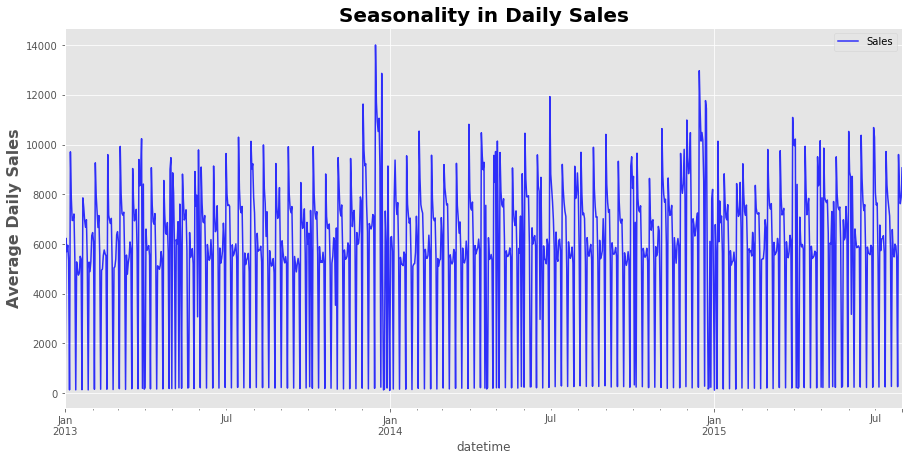

In [33]:
## Time Series plot for days
time_series_day = time_series.resample('D').mean()
time_series_day.plot(figsize=(15,7),color="b",alpha=0.8)
plt.ylabel("Average Daily Sales",size=16,weight='bold')
plt.title("Seasonality in Daily Sales",size=20,weight='bold')
plt.show()

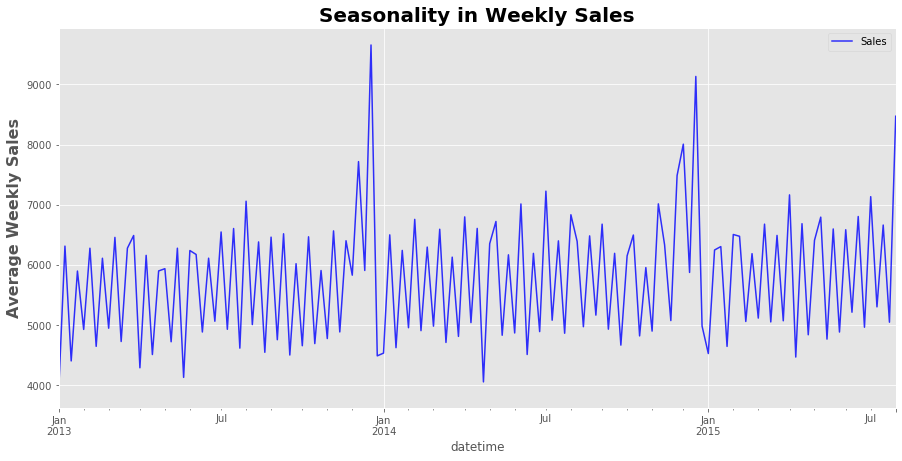

In [34]:
## Time Series plot for weeks
time_series_week = time_series.resample('W').mean()
time_series_week.plot(figsize=(15,7),color="b",alpha=0.8)
plt.ylabel("Average Weekly Sales",size=16,weight='bold')
plt.title("Seasonality in Weekly Sales",size=20,weight='bold')
plt.show()

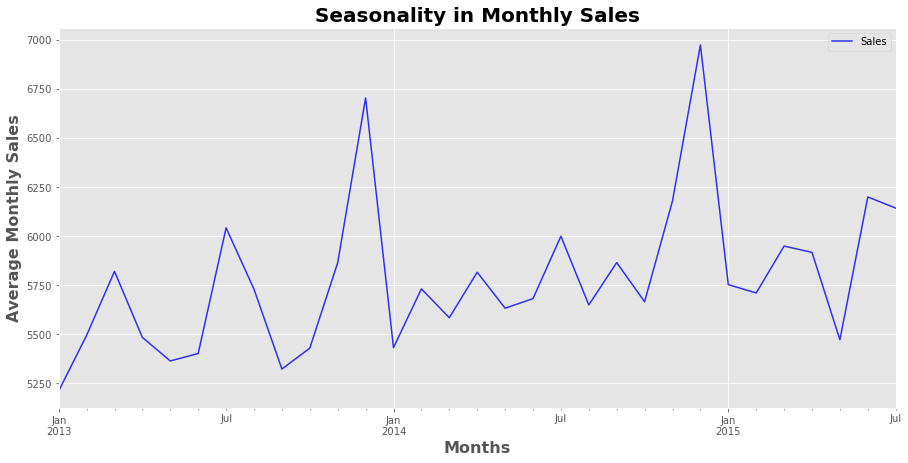

In [35]:
## Time Series plot for months
time_series_month = time_series.resample('M').mean()
time_series_month.plot(figsize=(15,7),color="b",alpha=0.8)
plt.xlabel("Months",size=16,weight='bold')
plt.ylabel("Average Monthly Sales",size=16,weight='bold')
plt.title("Seasonality in Monthly Sales",size=20,weight='bold')
plt.show()

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  object        
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  object        
 6   Promo          1017209 non-null  object        
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 69.8+ MB


#### Correlation between customers and sales

In [37]:
customer_sales = train_data[["Customers","Sales"]]
customer_sales

,Customers,Sales
0,555,5263
1,625,6064
2,821,8314
3,1498,13995
4,559,4822
...,...,...
1017204,0,0
1017205,0,0
1017206,0,0
1017207,0,0


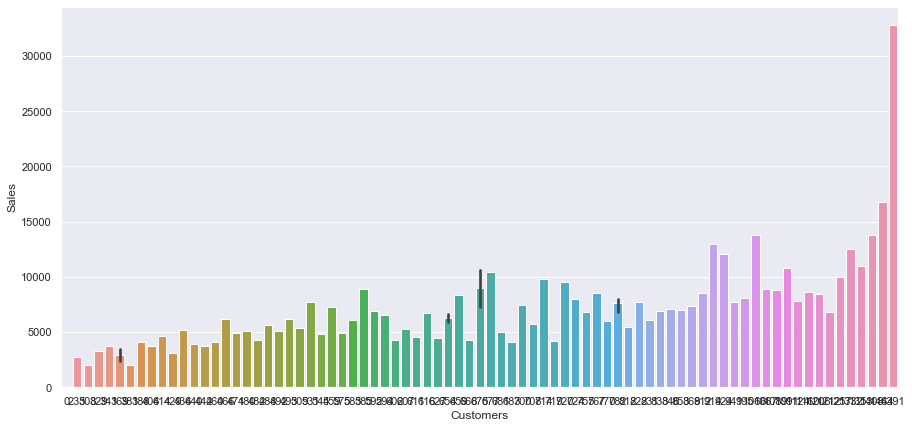

In [38]:
sns.set(rc={'figure.figsize':(15,7)})
sns.barplot(x="Customers",y="Sales",data=customer_sales.sample(100))

In [39]:
train_data["Customers"].corr(train_data["Sales"]) #correlation

0.8947107733017028

This means there is a strong linear relationship between the number of customers and sales for each day.
On average, the higher the number of customers the higher the sales

#### How does promo affect sales

In [40]:
promo = train_data[["Customers","Sales","Promo"]]
promo.head()

,Customers,Sales,Promo
0,555,5263,1
1,625,6064,1
2,821,8314,1
3,1498,13995,1
4,559,4822,1


In [41]:
promo_sales = promo.groupby("Promo").agg({"Sales": "sum"})
promo_sales = promo_sales.reset_index()
promo_customers = promo.groupby("Promo").agg({"Customers": "sum"})
promo_customers = promo_customers.reset_index()

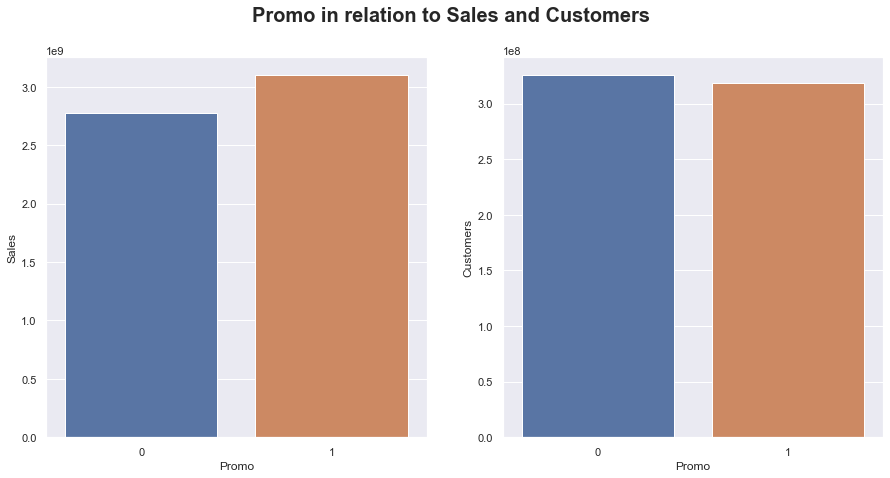

In [42]:
fig, axs = plt.subplots(1,2, figsize = (15,7))
plot1 = sns.barplot(x="Promo",y="Sales",data=promo_sales,ax=axs[0])
plot2 = sns.barplot(x="Promo",y="Customers",data=promo_customers,ax=axs[1])
fig.suptitle("Promo in relation to Sales and Customers",size=20,weight='bold')
plt.show()

#### Deployment of Promos in more effective ways

In [43]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   object 
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   object 
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 87.2+ KB


In [44]:
stores_promo = train_data[["Store","Promo","Sales"]]
stores_promo

,Store,Promo,Sales
0,1,1,5263
1,2,1,6064
2,3,1,8314
3,4,1,13995
4,5,1,4822
...,...,...,...
1017204,1111,0,0
1017205,1112,0,0
1017206,1113,0,0
1017207,1114,0,0


In [45]:
grouped_store = stores_promo.groupby(["Store"]).agg({"Sales": "sum"}).sort_values("Sales",ascending=False).reset_index()
grouped_store

,Store,Sales
0,262,19516842
1,817,17057867
2,562,16927322
3,1114,16202585
4,251,14896870
...,...,...
1110,263,2306075
1111,208,2302052
1112,198,2268273
1113,543,2179287


In [46]:
train_data["Open"].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [47]:
store_open = train_data[["Open","Sales"]]
store_open

,Open,Sales
0,1,5263
1,1,6064
2,1,8314
3,1,13995
4,1,4822
...,...,...
1017204,0,0
1017205,0,0
1017206,0,0
1017207,0,0


In [48]:
gr = store_open.groupby(["Open"]).agg({"Sales": "sum"})
gr = gr.reset_index()

In [49]:
open_weekdays = train_data[["DayOfWeek","Sales"]]
open_weekdays

,DayOfWeek,Sales
0,5,5263
1,5,6064
2,5,8314
3,5,13995
4,5,4822
...,...,...
1017204,2,0
1017205,2,0
1017206,2,0
1017207,2,0


In [50]:
gr1 = open_weekdays.groupby(["DayOfWeek"]).agg({"Sales": "sum"})
gr1 = gr1.reset_index()

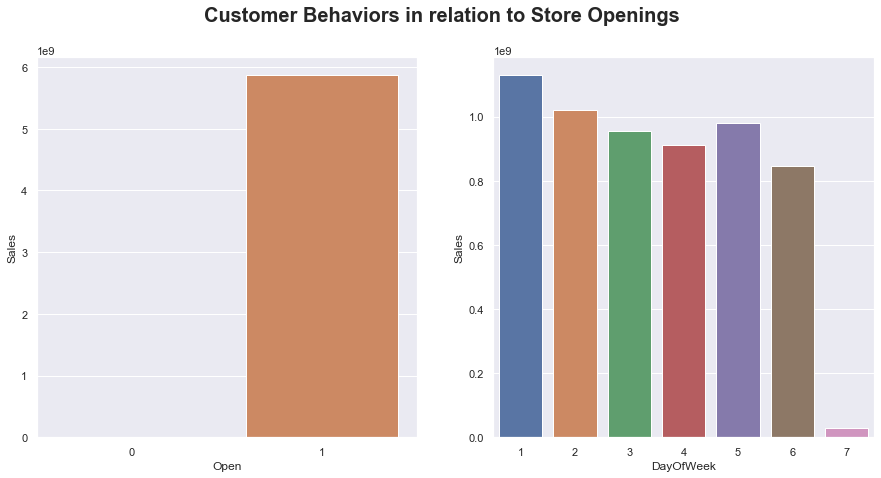

In [51]:
fig, axs = plt.subplots(1,2, figsize = (15,7))
plot1 = sns.barplot(x="Open",y="Sales",data=gr,ax=axs[0])
plot2 = sns.barplot(x="DayOfWeek",y="Sales",data=gr1,ax=axs[1])
fig.suptitle("Customer Behaviors in relation to Store Openings",size=20,weight='bold')
plt.show()

In [52]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [53]:
store_data["Store"].nunique()

1115

In [54]:
gry = train_data[["Store","Date","Sales"]]
gryy = gry.groupby(["Store"]).agg({"Sales": "sum"})
gryy

,Sales
Store,
1,3716854
2,3883858
3,5408261
4,7556507
5,3642818
...,...
1111,4091076
1112,7974294
1113,5196242


[Back to top](#Table-of-Contents)